In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table, hstack, vstack
from scipy.stats import ks_2samp, beta
from functools import reduce

import math
import mpl_style
import csv
import hex_scatter as hs

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [2]:
group_table = Table(fits.getdata('../group_table.fits'))

#cell initializing different indices for use later
#group_table indices
pair_ind = np.where(group_table['n_gal'] == 2)[0]
group_ind = np.where(group_table['n_gal'] > 2)[0]

halo_mass_val_ind = np.where(group_table['halo_mass'] > 2)[0]

high_mass_cent_ind = np.where(group_table['cent_mass'] >= 10.5)[0]
low_mass_cent_ind = np.where(group_table['cent_mass'] < 10.5)[0]

sf_cent_ind = np.where(group_table['sfing_central'] == 'SFing')[0]
passive_cent_ind = np.where(group_table['sfing_central'] == 'passive')[0]

red_cent_ind = np.where(group_table['cent_redblue'] == 'red')[0]
blue_cent_ind = np.where(group_table['cent_redblue'] == 'blue')[0]

spiral_cent_ind = np.where(group_table['cent_pfeat'] >= 0.8)[0]
smooth_cent_ind = np.where(group_table['cent_pfeat'] <= 0.2)[0]
int_cent_ind = np.intersect1d(np.where(group_table['cent_pfeat'] < 0.8)[0],np.where(group_table['cent_pfeat'] > 0.2)[0])

spiral_half_cent_ind = np.where(group_table['cent_pfeat'] >= 0.5)[0]
smooth_half_cent_ind = np.where(group_table['cent_pfeat'] < 0.5)[0]

#central morphology/color of groups
redelliptical_cent_ind = np.intersect1d(red_cent_ind, smooth_cent_ind) 
blueelliptical_cent_ind = np.intersect1d(blue_cent_ind, smooth_cent_ind)
redspiral_cent_ind = np.intersect1d(red_cent_ind, spiral_cent_ind)
bluespiral_cent_ind = np.intersect1d(blue_cent_ind, spiral_cent_ind)

In [173]:
## plan: bin galaxies based on halo mass, then compute average

def halo_mass_frac(fracs, nums, hmasses, labels, ylabel, nbins=4): 
    #fracs is a list of arrays for each line to plot with satellite fraction
    #hmasses are the corresponding halo masses for fracs
    f = plt.figure(figsize=(8,8))
    
    c = 0.95
    colors = ['b', 'r']
    
    all_mass = np.concatenate(hmasses)
    mbins = np.percentile(all_mass, np.arange(0,100,100/(nbins+1)))
    for i in range(len(fracs)): #loop thru arrays in fracs
        mass_hist, b = np.histogram(hmasses[i], density=False, bins=mbins)
        whichmassbin = np.digitize(hmasses[i], mbins[:-1]) #this gives which # mass bin each entry is in
        whichmassbin = whichmassbin - 1
        
        binned_fracs = []
        frac_err = []
        bin_plot_pts = []
        
        for b in range(len(mbins[:-1])): #now loop thru bins to calculate avg fraction for each 
            mass_ind = np.where(whichmassbin == b)[0] 
            print(len(mass_ind))
            avg_frac = np.mean(fracs[i][mass_ind]) #average fraction in mass bin
            all_num = np.sum(nums[i][mass_ind]) #total number of satellites in the bin
            #success_num = np.sum(fracs[i][mass_ind]*nums[i][mass_ind])
            success_num = avg_frac*all_num
            
            p_lower = beta.ppf((1-c)/2.,success_num+1,all_num-success_num+1)
            p_upper = beta.ppf(1-(1-c)/2.,success_num+1,all_num-success_num+1)
            yerr = np.array((avg_frac - p_lower, p_upper - avg_frac))
            
            binned_fracs.append(avg_frac)
            frac_err.append(yerr)
            bin_plot_pts.append((mbins[b] + mbins[b+1])/2)

        frac_err = np.transpose(frac_err)
        plt.errorbar(bin_plot_pts, binned_fracs, yerr=frac_err, capsize=5, color=colors[i], label=labels[i])
    plt.legend()
    plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
    plt.ylabel(ylabel)
    return f
            

48
43
32
269
273
601


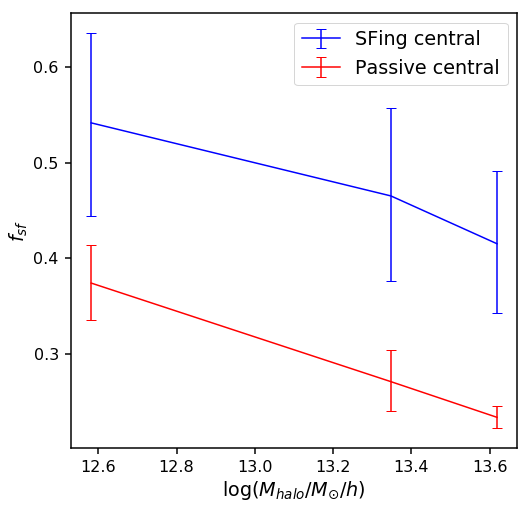

In [174]:
plt.style.use(mpl_style.style1)

sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind))
passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind))

sfing_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_cent_group_ind]
passive_cent_ssfr_frac = group_table['sat_sf_frac'][passive_cent_group_ind]

sfing_cent_sat_num = group_table['n_gal'][sfing_cent_group_ind] - 1
passive_cent_sat_num = group_table['n_gal'][passive_cent_group_ind] - 1

frac_arrs = [sfing_cent_ssfr_frac, passive_cent_ssfr_frac]
num_arrs = [sfing_cent_sat_num, passive_cent_sat_num]

sfing_cent_halo_mass = group_table['halo_mass'][sfing_cent_group_ind]
passive_cent_halo_mass = group_table['halo_mass'][passive_cent_group_ind]

halo_mass_arrs = [sfing_cent_halo_mass, passive_cent_halo_mass]

fig1 = halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['SFing central', 'Passive central'], r'$f_{sf}$', nbins=3)
plt.show()

74
66
65
73
132
139
140
338


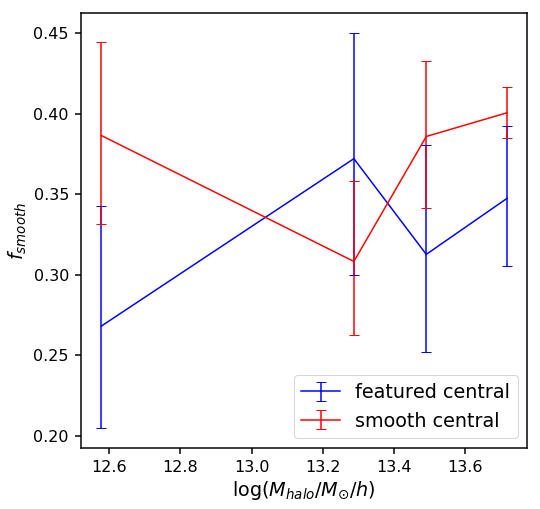

In [175]:
plt.style.use(mpl_style.style1)

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_smooth_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_smooth_frac'][smooth_cent_group_ind]

spiral_cent_sat_num = group_table['n_gal'][spiral_cent_group_ind] - 1
smooth_cent_sat_num = group_table['n_gal'][smooth_cent_group_ind] - 1

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]
num_arrs = [spiral_cent_sat_num, smooth_cent_sat_num]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{smooth}$')
plt.show()

90
81
107
167
175
407


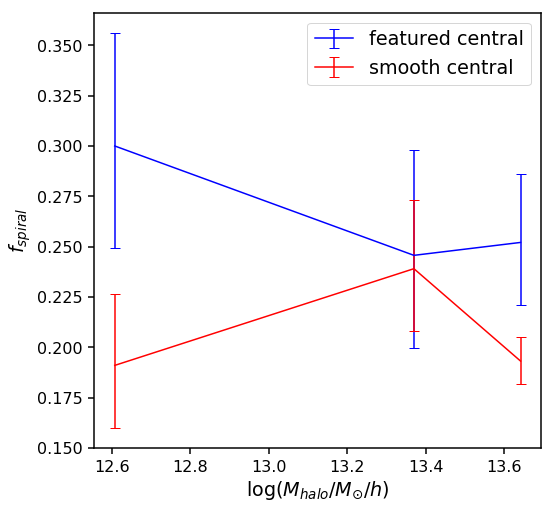

In [176]:
plt.style.use(mpl_style.style1)

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_spiral_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_spiral_frac'][smooth_cent_group_ind]

spiral_cent_sat_num = group_table['n_gal'][spiral_cent_group_ind]
smooth_cent_sat_num = group_table['n_gal'][smooth_cent_group_ind]

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]
num_arrs = [spiral_cent_sat_num, smooth_cent_sat_num]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{spiral}$', nbins=3)
plt.show()

115
110
140
202
206
493


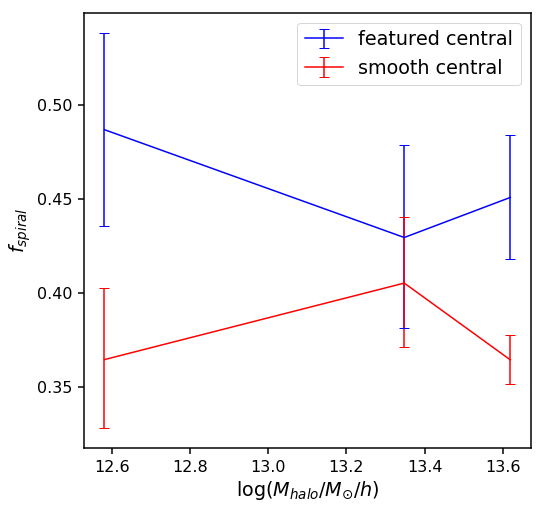

In [177]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria

spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind))
smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind))

spiral_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_cent_group_ind]
smooth_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_cent_group_ind]

spiral_cent_sat_num = group_table['n_gal'][spiral_cent_group_ind]
smooth_cent_sat_num = group_table['n_gal'][smooth_cent_group_ind]

frac_arrs = [spiral_cent_ssfr_frac, smooth_cent_ssfr_frac]
num_arrs = [spiral_cent_sat_num, smooth_cent_sat_num]

spiral_cent_halo_mass = group_table['halo_mass'][spiral_cent_group_ind]
smooth_cent_halo_mass = group_table['halo_mass'][smooth_cent_group_ind]

halo_mass_arrs = [spiral_cent_halo_mass, smooth_cent_halo_mass]

fig2 = halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['featured central', 'smooth central'], r'$f_{spiral}$', nbins=3)
plt.show()

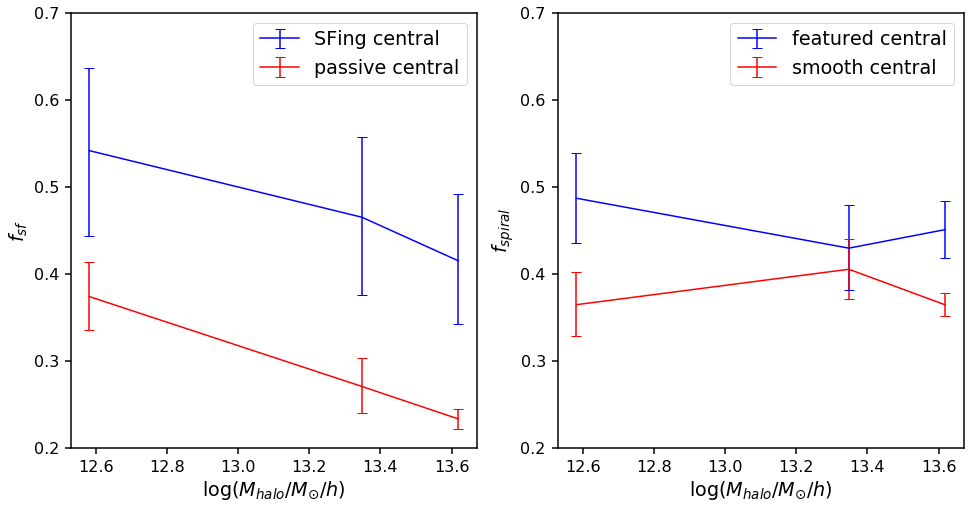

In [178]:
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)

xpts = [x[0] for x in fig1.gca().get_lines()[0].get_xydata()]

sfing_cent_ssfr_line = np.array([x[1] for x in fig1.gca().get_lines()[0].get_xydata()])
sfing_cent_ssfr_lower = sfing_cent_ssfr_line - np.array([x[1] for x in fig1.gca().get_lines()[1].get_xydata()]) 
sfing_cent_ssfr_upper = np.array([x[1] for x in fig1.gca().get_lines()[2].get_xydata()]) - sfing_cent_ssfr_line

passive_cent_ssfr_line = np.array([x[1] for x in fig1.gca().get_lines()[3].get_xydata()])
passive_cent_ssfr_lower = passive_cent_ssfr_line - np.array([x[1] for x in fig1.gca().get_lines()[4].get_xydata()]) 
passive_cent_ssfr_upper = np.array([x[1] for x in fig1.gca().get_lines()[5].get_xydata()]) - passive_cent_ssfr_line

plt.errorbar(xpts, sfing_cent_ssfr_line, yerr=[sfing_cent_ssfr_lower, sfing_cent_ssfr_upper], color='b', label='SFing central', capsize=5)
plt.errorbar(xpts, passive_cent_ssfr_line, yerr=[passive_cent_ssfr_lower, passive_cent_ssfr_upper], color='r', label='passive central', capsize=5)

plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
plt.ylabel(r'$f_{sf}$')
plt.ylim(0.2,0.7)
plt.legend()

plt.subplot(1,2,2)
xpts = [x[0] for x in fig2.gca().get_lines()[0].get_xydata()]

spiral_cent_ssfr_line = np.array([x[1] for x in fig2.gca().get_lines()[0].get_xydata()])
spiral_cent_ssfr_lower = spiral_cent_ssfr_line - np.array([x[1] for x in fig2.gca().get_lines()[1].get_xydata()]) 
spiral_cent_ssfr_upper = np.array([x[1] for x in fig2.gca().get_lines()[2].get_xydata()]) - spiral_cent_ssfr_line

smooth_cent_ssfr_line = np.array([x[1] for x in fig2.gca().get_lines()[3].get_xydata()])
smooth_cent_ssfr_lower = smooth_cent_ssfr_line - np.array([x[1] for x in fig2.gca().get_lines()[4].get_xydata()]) 
smooth_cent_ssfr_upper = np.array([x[1] for x in fig2.gca().get_lines()[5].get_xydata()]) - smooth_cent_ssfr_line

plt.errorbar(xpts, spiral_cent_ssfr_line, yerr=[spiral_cent_ssfr_lower, spiral_cent_ssfr_upper], color='b', label='featured central', capsize=5)
plt.errorbar(xpts, smooth_cent_ssfr_line, yerr=[smooth_cent_ssfr_lower, smooth_cent_ssfr_upper], color='r', label='smooth central', capsize=5)

plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
plt.ylabel(r'$f_{spiral}$')
plt.ylim(0.2,0.7)
plt.legend()


31
31
43
60
60
140


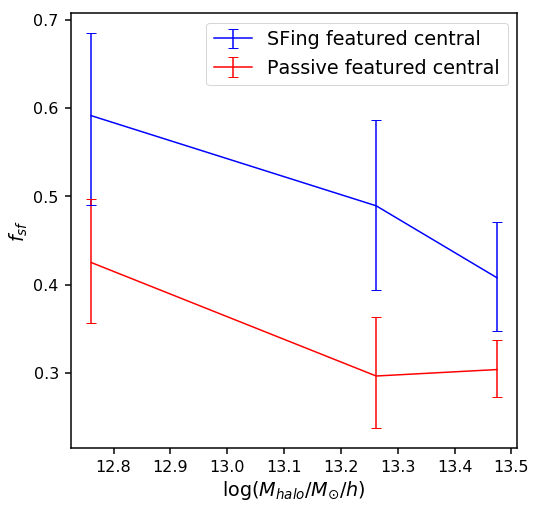

In [179]:
plt.style.use(mpl_style.style1)

sfing_spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, spiral_half_cent_ind))
passive_spiral_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, spiral_half_cent_ind))

sfing_spiral_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_spiral_cent_group_ind]
passive_spiral_cent_ssfr_frac = group_table['sat_sf_frac'][passive_spiral_cent_group_ind]

sfing_spiral_cent_sat_num = group_table['n_gal'][sfing_spiral_cent_group_ind]
passive_spiral_cent_sat_num = group_table['n_gal'][passive_spiral_cent_group_ind]

frac_arrs = [sfing_spiral_cent_ssfr_frac, passive_spiral_cent_ssfr_frac]
num_arrs = [sfing_spiral_cent_sat_num, passive_spiral_cent_sat_num]

sfing_spiral_cent_halo_mass = group_table['halo_mass'][sfing_spiral_cent_group_ind]
passive_spiral_cent_halo_mass = group_table['halo_mass'][passive_spiral_cent_group_ind]

halo_mass_arrs = [sfing_spiral_cent_halo_mass, passive_spiral_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['SFing featured central', 'Passive featured central'], r'$f_{sf}$', nbins=3)
plt.show()

10
8
0
215
217
451


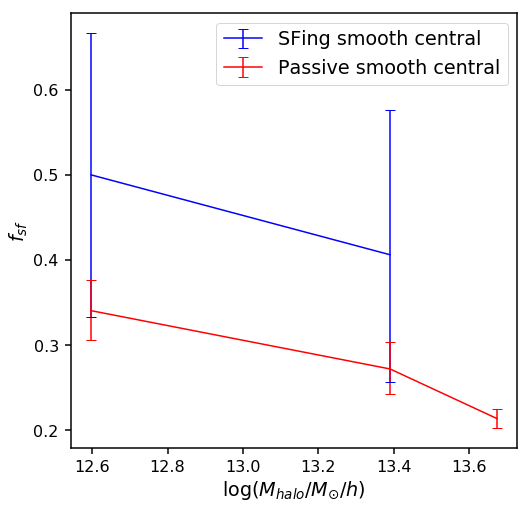

In [180]:
plt.style.use(mpl_style.style1)

sfing_smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, smooth_half_cent_ind))
passive_smooth_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, smooth_half_cent_ind))

sfing_smooth_cent_ssfr_frac = group_table['sat_sf_frac'][sfing_smooth_cent_group_ind]
passive_smooth_cent_ssfr_frac = group_table['sat_sf_frac'][passive_smooth_cent_group_ind]

sfing_smooth_cent_sat_num = group_table['n_gal'][sfing_smooth_cent_group_ind]
passive_smooth_cent_sat_num = group_table['n_gal'][passive_smooth_cent_group_ind]

frac_arrs = [sfing_smooth_cent_ssfr_frac, passive_smooth_cent_ssfr_frac]
num_arrs = [sfing_smooth_cent_sat_num, passive_smooth_cent_sat_num]

sfing_smooth_cent_halo_mass = group_table['halo_mass'][sfing_smooth_cent_group_ind]
passive_smooth_cent_halo_mass = group_table['halo_mass'][passive_smooth_cent_group_ind]

halo_mass_arrs = [sfing_smooth_cent_halo_mass, passive_smooth_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['SFing smooth central', 'Passive smooth central'], r'$f_{sf}$', nbins=3)
plt.show()

25
26
54
6
4
8


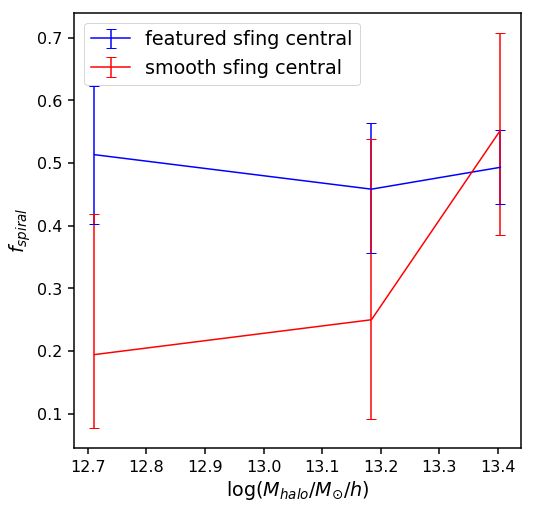

In [181]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria

spiral_sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind, sf_cent_ind))
smooth_sfing_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind, sf_cent_ind))

spiral_sfing_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_sfing_cent_group_ind]
smooth_sfing_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_sfing_cent_group_ind]

spiral_sfing_cent_sat_num = group_table['n_gal'][spiral_sfing_cent_group_ind]
smooth_sfing_cent_sat_num = group_table['n_gal'][smooth_sfing_cent_group_ind]

frac_arrs = [spiral_sfing_cent_ssfr_frac, smooth_sfing_cent_ssfr_frac]
num_arrs = [spiral_sfing_cent_sat_num, smooth_sfing_cent_sat_num]

spiral_sfing_cent_halo_mass = group_table['halo_mass'][spiral_sfing_cent_group_ind]
smooth_sfing_cent_halo_mass = group_table['halo_mass'][smooth_sfing_cent_group_ind]

halo_mass_arrs = [spiral_sfing_cent_halo_mass, smooth_sfing_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['featured sfing central', 'smooth sfing central'], r'$f_{spiral}$',nbins=3)
plt.show()

84
76
100
202
209
472


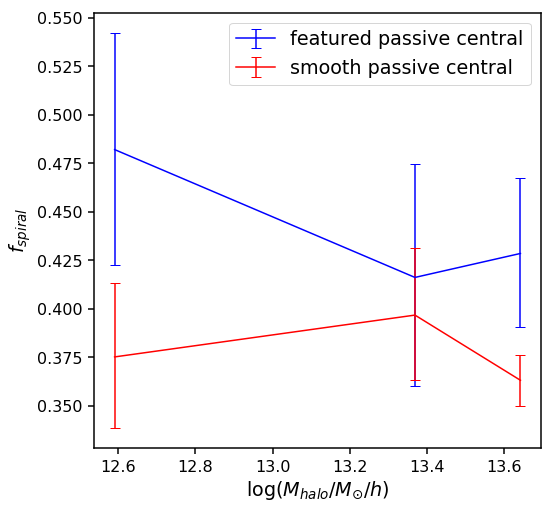

In [182]:
plt.style.use(mpl_style.style1)
##this plot uses the 1/2 fraction criteria
#morphology conformity for 

spiral_passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind, passive_cent_ind))
smooth_passive_cent_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind, passive_cent_ind))

spiral_passive_cent_ssfr_frac = group_table['sat_spiral_half_frac'][spiral_passive_cent_group_ind]
smooth_passive_cent_ssfr_frac = group_table['sat_spiral_half_frac'][smooth_passive_cent_group_ind]

spiral_passive_cent_sat_num = group_table['n_gal'][spiral_passive_cent_group_ind]
smooth_passive_cent_sat_num = group_table['n_gal'][smooth_passive_cent_group_ind]

frac_arrs = [spiral_passive_cent_ssfr_frac, smooth_passive_cent_ssfr_frac]
num_arrs = [spiral_passive_cent_sat_num, smooth_passive_cent_sat_num]

spiral_passive_cent_halo_mass = group_table['halo_mass'][spiral_passive_cent_group_ind]
smooth_passive_cent_halo_mass = group_table['halo_mass'][smooth_passive_cent_group_ind]

halo_mass_arrs = [spiral_passive_cent_halo_mass, smooth_passive_cent_halo_mass]

halo_mass_frac(frac_arrs, num_arrs, halo_mass_arrs, ['featured passive central', 'smooth passive central'], r'$f_{spiral}$', nbins=3)
plt.show()